<a href="https://colab.research.google.com/github/Nicohim87/DeepLearning/blob/main/Pertemuan10/session10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
import os

In [20]:
os.listdir('/content/')

['.config', 'Game_of_Thrones_Script.csv', 'sample_data']

In [21]:
df = pd.read_csv('/content/Game_of_Thrones_Script.csv')
df.drop(columns=['Release Date', 'Season', 'Episode', 'Episode Title', 'Name'], inplace=True)
df.dropna(inplace=True)
df.head()

,Sentence
0,What do you expect? They're savages. One lot s...
1,I've never seen wildlings do a thing like this...
2,How close did you get?
3,Close as any man would.
4,We should head back to the wall.


In [22]:
sentences = df['Sentence']

# **Tokenizer**

In [23]:
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
input_sequences = [tokenizer.encode(s, add_special_tokens=True) for s in sentences]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
MAX_SEQUENCE_LENGTH = 25

x = [seq[:-1] for seq in input_sequences]
y = [seq[1:] for seq in input_sequences]

x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH - 1, truncating='post', padding='post')
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH - 1, truncating='post', padding='post')

# **Train Test Splitting**

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=.8)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size=.5)

# **Attention**

In [29]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)

    scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [35]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

def positional_encoding(position, d_model):
    angle_rads = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(position * angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(position * angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# **Model**

In [44]:
NUM_HEADS = 8
D_MODEL = 128
D_FF = 512

NUM_LAYERS = 2
INPUT_VOCAB_SIZE = len(tokenizer.vocab)
MAX_POS_ENC = MAX_SEQUENCE_LENGTH
DROPOUT_RATE = 0.3
EPOCH = 3
BATCH_SIZE = 8

In [38]:
inputs = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH - 1,))
x = tf.keras.layers.Embedding(INPUT_VOCAB_SIZE, D_MODEL)(inputs)
x *= tf.math.sqrt(tf.cast(D_MODEL, tf.float32))
x += positional_encoding(MAX_POS_ENC, D_MODEL)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)

for _ in range(NUM_LAYERS):
    attention_output, _ = MultiHeadAttention(D_MODEL, NUM_HEADS)(x, x, x, None)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + x)
    x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    ffn_output = point_wise_feed_forward_network(D_MODEL, D_FF)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ffn_output + x)

outputs = tf.keras.layers.Dense(INPUT_VOCAB_SIZE)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 24)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 24, 128)        │      3,711,488 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 24, 128)        │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 128)        │              0 │ multiply_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24, 128)        │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 128),    │         66,048 │ dropout[0][0],         │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ dropout[0][0],         │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 24, 128)        │              0 │ multi_head_attention[… │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 128)        │            256 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 24, 128)        │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 24, 128)        │        131,712 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 24, 128)        │              0 │ sequential[0][0],      │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 128)        │            256 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ [(None, None, 128),    │         66,048 │ layer_normalization_1… │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ layer_normalization_1… │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 24, 128)        │              0 │ multi_head_attention_… │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2

 Total params: 7,848,516 (29.94 MB)

 Trainable params: 7,848,516 (29.94 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(
    x_train, np.expand_dims(y_train, -1),
    epochs = EPOCH,
    batch_size = BATCH_SIZE,
    validation_data = (x_val, np.expand_dims(y_val, -1)),
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/3
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.4102 - loss: 6.7715 - val_accuracy: 0.4304 - val_loss: 5.8537
Epoch 2/3
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.4360 - loss: 5.7963 - val_accuracy: 0.4304 - val_loss: 5.8537
Epoch 3/3
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.4365 - loss: 5.7918 - val_accuracy: 0.4304 - val_loss: 5.8537


In [46]:
loss, accuracy = model.evaluate(x_test, np.expand_dims(y_test, -1))
print(f'Loss: {loss}, Accuracy: {accuracy}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4317 - loss: 5.8404
Loss: 5.786543369293213, Accuracy: 0.43695101141929626


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

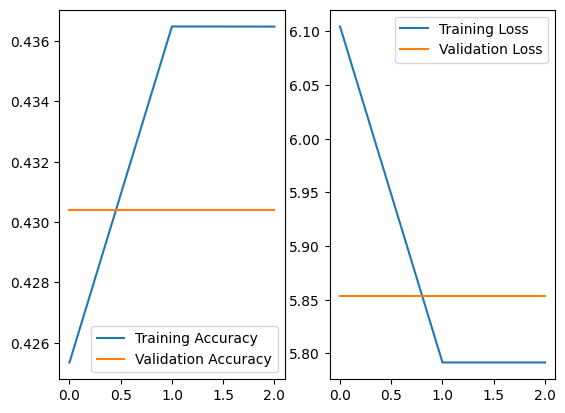

In [49]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.plot

In [50]:
def predict_next_token(model, tokenizer, text):
    encoded_input = tokenizer.encode(text, add_special_tokens = True)
    padded_input = pad_sequences([encoded_input], maxlen=MAX_SEQUENCE_LENGTH - 1, truncating='post', padding='post')

    prediction = model.predict(padded_input)
    predicted_index = np.argmax(prediction[0, -1, :])

    return tokenizer.decode([predicted_index])

In [51]:
text = "Syrio says every hurt is a lesson and lesson makes you better. Tommorow I'm going to be"
predict_next_token(model, tokenizer, text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'Charlie'